<a href="https://www.kaggle.com/code/nayeem000/unet-pytorch-brain-tumor?scriptVersionId=136108444" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-dataset/Unet_dataset/masks_brain_tum/img_160.jpg
/kaggle/input/brain-tumor-dataset/Unet_dataset/images_brain_tum/img_160.jpg


In [2]:
import torch
from torch import nn
import cv2
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

## Device agnostic code

In [3]:
!nvidia-smi

Sat Jul  8 07:54:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

## Unet Architecture
[https://arxiv.org/pdf/1505.04597.pdf](paper)

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()
    
    def forward(self, x:torch.Tensor):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d((2, 2))
    
    def forward(self, x:torch.Tensor):
        x = self.conv(x)
        p = self.pool(x)
        return x, p
        
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 
                                     kernel_size = 2, stride = 2, padding = 0)
        self.conv = DoubleConv(out_channels + out_channels, out_channels)
    
    def forward(self, x:torch.Tensor, skip):
        x = self.up(x)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

        
class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder1 = Encoder(3, 64)
        self.encoder2 = Encoder(64, 128)
        self.encoder3 = Encoder(128, 256)
        self.encoder4 = Encoder(256, 512)
        
        self.bottleneck = DoubleConv(512, 1024)
        
        self.decoder1 = Decoder(1024, 512)
        self.decoder2 = Decoder(512, 256)
        self.decoder3 = Decoder(256, 128)
        self.decoder4 = Decoder(128, 64)
        
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        
    def forward(self, inputs):
        s1, p1 = self.encoder1(inputs)
        s2, p2 = self.encoder2(p1)
        s3, p3 = self.encoder3(p2)
        s4, p4 = self.encoder4(p3)

        b = self.bottleneck(p4)

        d1 = self.decoder1(b, s4)
        d2 = self.decoder2(d1, s3)
        d3 = self.decoder3(d2, s2)
        d4 = self.decoder4(d3, s1)

        outputs = self.outputs(d4)

        return outputs

# if __name__ == "__main__":
#     torch.manual_seed(42)
#     x = torch.randn((2, 3, 512, 512)).to(device)
#     f = Unet().to(device)
#     y = f(x)
#     print(next(f.parameters()).device)
#     print(y.shape)

## Reading image data

/kaggle/input/brain-tumor-dataset/Unet_dataset/masks_brain_tum/img_160.jpg



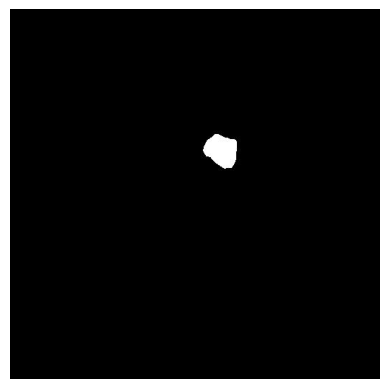

/kaggle/input/brain-tumor-dataset/Unet_dataset/images_brain_tum/img_160.jpg



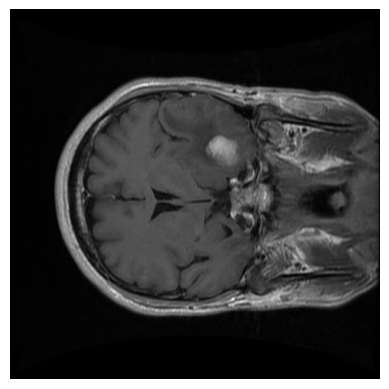

In [6]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for img in filenames:
        print(f"{os.path.join(dirname, img)}\n")
        img_array = cv2.imread(os.path.join(dirname,img))  
        plt.imshow(img_array)
        plt.axis(False)
        plt.show()
        break
    

In [8]:
import random
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms


In [9]:
from pathlib import PosixPath

class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = [str(path) for path in images_path]
        self.masks_path = [str(path) for path in masks_path]
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = image/255.0 ## (512, 512, 3)
        image = np.transpose(image, (2, 0, 1))  ## (3, 512, 512)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask/255.0   ## (512, 512)
        mask = np.expand_dims(mask, axis=0) ## (1, 512, 512)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

In [10]:

data_transform = transforms.Compose([
    transforms.ToTensor()  
])


def plot_transformed_images(image_paths, transform, n, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


## Creating traing and testing image array

total: 705
trian_images: 625 |  test: 80
trian_mask: 625 |  test: 80


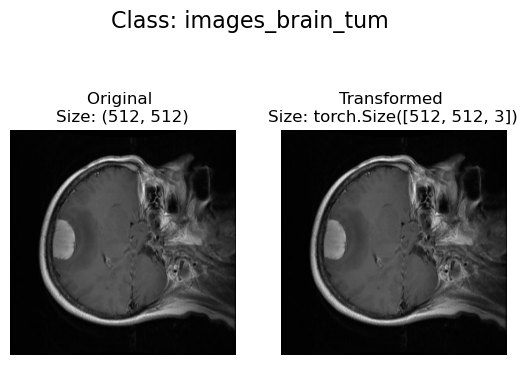

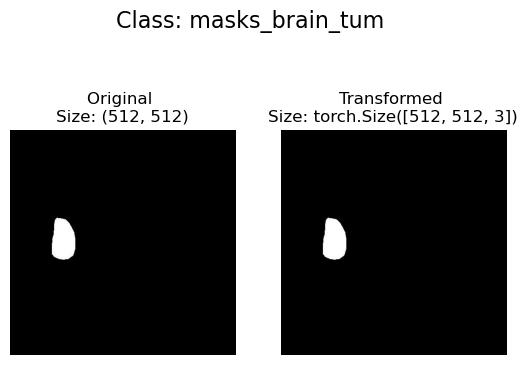

In [11]:
from pathlib import Path
random.seed(42)

data_path = Path("/kaggle/input/")

image_path_list = list(data_path.glob("*/*/images_brain_tum/*.jpg"))
mask_path_list = list(data_path.glob("*/*/masks_brain_tum/*.jpg"))

print(f"total: {len(image_path_list)}")

# img_path = np.array(image_path_list)
# mask_path = np.array(mask_path_list)

# print(image_path_list)
# print(img_path)

training_img, test_img = image_path_list[80:], image_path_list[:80]
training_mask, test_mask = mask_path_list[80:], mask_path_list[:80]
# training.shape, test.shape
print(f"trian_images: {len(training_img)} |  test: {len(test_img)}")
print(f"trian_mask: {len(training_mask)} |  test: {len(test_mask)}")


plot_transformed_images(training_img, 
                        transform= data_transform, 
                        n=1)

plot_transformed_images(training_mask, 
                        transform= data_transform, 
                        n=1)

In [12]:
train_dataset = DriveDataset(training_img, training_mask)
test_dataset = DriveDataset(test_img, test_mask)

train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size=8,
        shuffle=True
    )

test_dataloader = DataLoader(
        dataset=test_dataset,
        batch_size=8,
    )

# train_dataset.shape
img, label = next(iter(train_dataloader))
img.shape, label.shape

(torch.Size([8, 3, 512, 512]), torch.Size([8, 1, 512, 512]))

## DiceBCELoss function

In [13]:
## https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch#Loss-Function-Reference-for-Keras-&-PyTorch

import torch.nn.functional as F

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        inputs = F.sigmoid(inputs)       
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [14]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    model.train()
    
    train_loss = 0
    
    for batch, (X, y) in tqdm(enumerate(dataloader)):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()


    train_loss = train_loss / len(dataloader)
    return train_loss



def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    model.eval() 
    
    test_loss= 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
    
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
    test_loss = test_loss / len(dataloader)
    return test_loss

## Training and Testing loop

In [15]:

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn,
          epochs: int = 5):
    
    results = {"train_loss": [],
        "test_loss": [],
    }
    
    best_loss = 0.0
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        
        test_loss = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | test_loss: {test_loss:.4f}")


        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    return results

In [16]:
from timeit import default_timer as timer 

torch.manual_seed(42) 
torch.cuda.manual_seed(42)

NUM_EPOCHS = 10

model_0 = Unet().to(device)


loss_fn = DiceBCELoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

start_time = timer()

model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | train_loss: 1.0626 | test_loss: 1.0293


0it [00:00, ?it/s]

Epoch: 2 | train_loss: 0.6313 | test_loss: 1.0892


0it [00:00, ?it/s]

Epoch: 3 | train_loss: 0.3991 | test_loss: 1.1077


0it [00:00, ?it/s]

Epoch: 4 | train_loss: 0.2994 | test_loss: 0.3872


0it [00:00, ?it/s]

Epoch: 5 | train_loss: 0.2723 | test_loss: 0.3794


0it [00:00, ?it/s]

Epoch: 6 | train_loss: 0.2310 | test_loss: 0.2977


0it [00:00, ?it/s]

Epoch: 7 | train_loss: 0.2042 | test_loss: 0.6089


0it [00:00, ?it/s]

Epoch: 8 | train_loss: 0.1751 | test_loss: 0.3491


0it [00:00, ?it/s]

Epoch: 9 | train_loss: 0.1581 | test_loss: 0.4312


0it [00:00, ?it/s]

Epoch: 10 | train_loss: 0.1419 | test_loss: 0.2999
Total training time: 735.999 seconds


## Loss curve


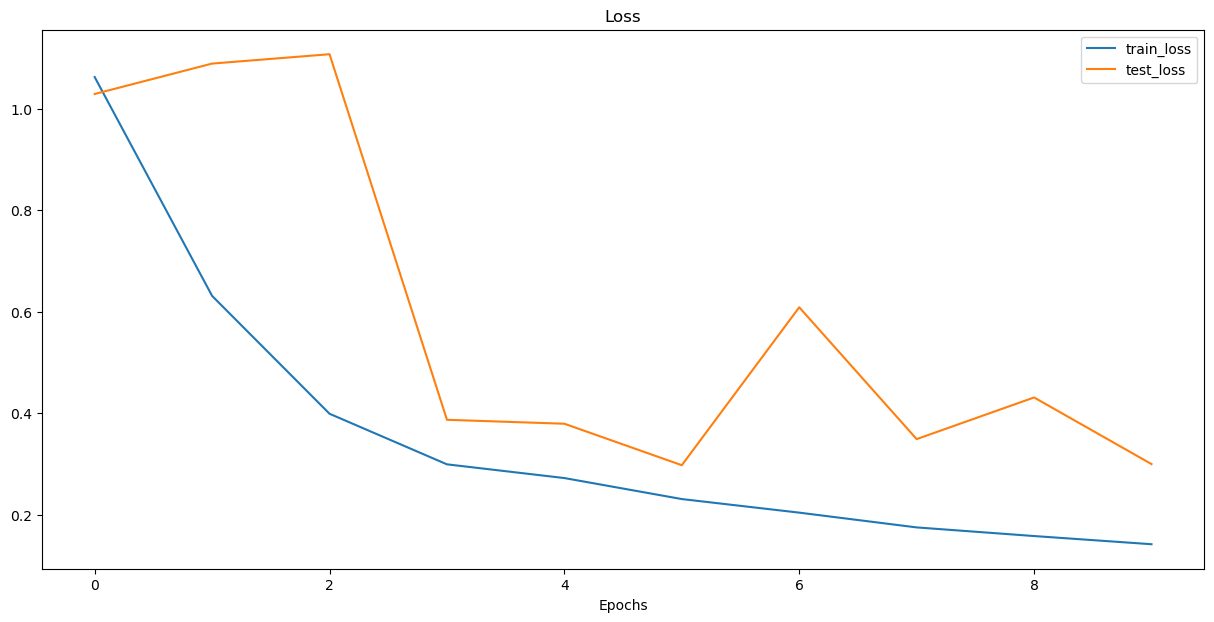

In [17]:
def plot_loss_curve(results):
    loss = results['train_loss']
    test_loss = results['test_loss']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

plot_loss_curve(model_0_results)

In [18]:
torch.save(model_0, 'Unet_model.pth')


### Predicting with Unet model

In [19]:
sample_img, sample_mask = next(iter(test_dataloader))
sample_img[0].shape, sample_mask[0].shape

(torch.Size([3, 512, 512]), torch.Size([1, 512, 512]))

In [26]:
model = model_0.cpu()
model_0.eval()
with torch.no_grad():
    pred_y = model_0(sample_img[1].unsqueeze(dim=0).cpu())
    pred_y = torch.sigmoid(pred_y)

In [27]:
pred_y.shape

torch.Size([1, 1, 512, 512])

(-0.5, 511.5, 511.5, -0.5)

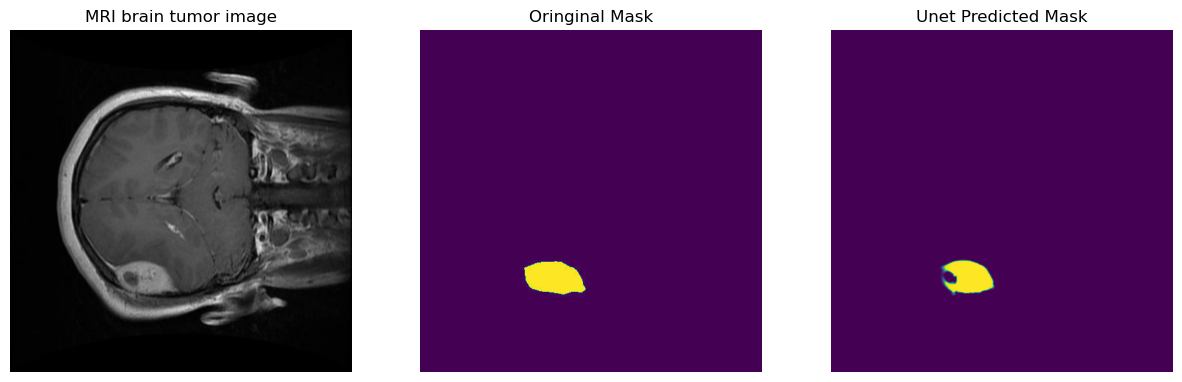

In [28]:
f, (ax1, ax2,ax3) = plt.subplots(1,3)
f.set_figheight(15)
f.set_figwidth(15)
ax1.imshow(np.transpose(sample_img[1], (1, 2, 0)))
ax1.set_title("Brain tumor MRI image")
ax1.axis(False)

ax2.imshow(sample_mask[1].squeeze())
ax2.set_title("Oringinal Mask")
ax2.axis(False)

ax3.imshow(pred_y.squeeze())
ax3.set_title("Unet Predicted Mask")
ax3.axis(False)